# Homework 3 - Adversarial Attacks and Contrastive Learning

### Submission in pairs unless otherwise authorized
<ul>
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p>
You should submit three files:
</p>
<ul">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p>
All files should be in the following format: "HW3_ID1_ID2.file"
<br>
Good Luck!
</p>

Libraries that can be used in this assignment:

- PyTorch (torch, torchvision, torch.optim, torch.nn, ...) -- Any other deep learning libraries such as keras are prohibited
- NumPy
- Any libraries used for visualization
- PIL (for image processing)

For any libraries other than those listed above, you may ask in the forum.

## Part 1 - Training a CNN on SVHN

Train a classifier on the dataset SVHN (Street View House Numbers), available through ```torchvision.datasets```. The model accuracy should reach at least 90% on the test set. You're free to add as many data augmentations as necessary. Take into consideration that any serious augmentations (like normalization) should be reversed when displaying images in future sections.

Using device: cuda


Training set size: 73257
Testing set size: 26032


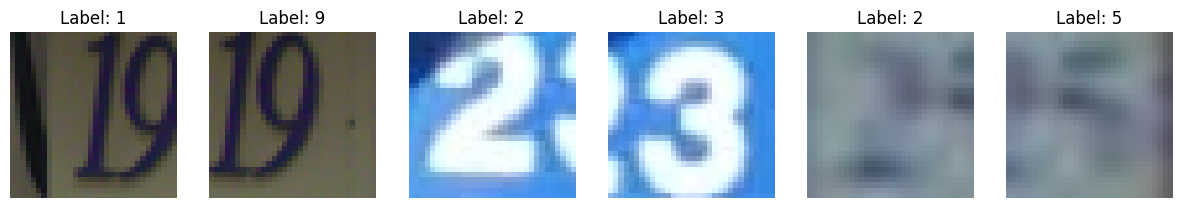

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momen

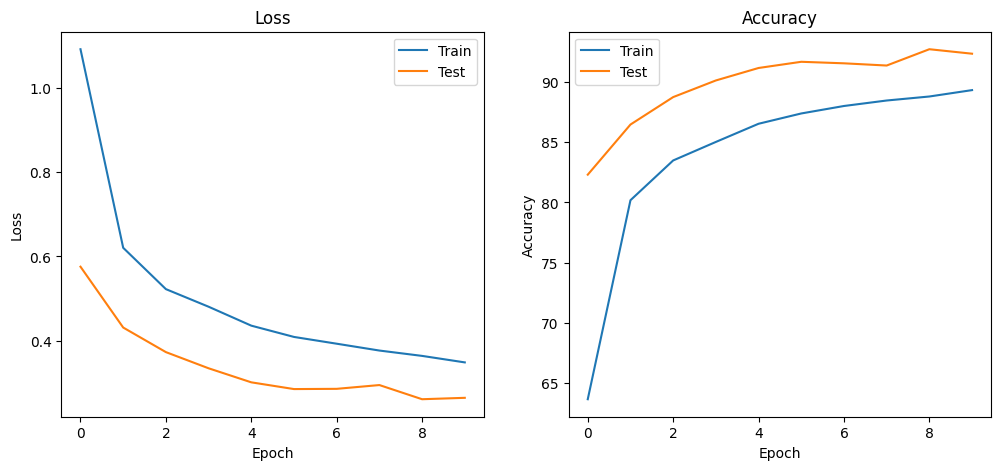

/tmp/ipykernel_6422/4289020973.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))


Loaded Best Model -> Test Acc: 92.74%


In [16]:
import torch
if not hasattr(torch, '_six'):
    import six
    torch._six = six

if not hasattr(six, 'string_classes'):
    six.string_classes = (str,)

if not hasattr(torch, '_six'):
    torch._six = six
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# For reproducibility (to some extent)
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Transform for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Transform for test (no random augmentations)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download and create train/test datasets
raw_train = SVHN(root='./data', split='train', download=False, transform=transforms.ToTensor())
raw_test = SVHN(root='./data', split='test', download=False, transform=transforms.ToTensor())
train_dataset = SVHN(root='./data', split='train', download=False, transform=train_transform)
test_dataset  = SVHN(root='./data', split='test',  download=False, transform=test_transform)

print("Training set size:", len(train_dataset))
print("Testing set size:", len(test_dataset))

batch_size = 128

raw_train_loader = DataLoader(raw_train, batch_size=6, shuffle=False)
raw_test_loader = DataLoader(raw_test, batch_size=6, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

def undo_train_transform(image_tensor, original_size=(32, 32), crop_padding=4, flipped=False):
    # Step 1: Undo RandomCrop
    # Assuming padding was added, crop the center region back to original size
    padded_size = original_size[0] + 2 * crop_padding
    center_crop_start = crop_padding
    center_crop_end = padded_size - crop_padding
    image_tensor = image_tensor[:, center_crop_start:center_crop_end, center_crop_start:center_crop_end]

    # Step 2: Undo RandomHorizontalFlip
    if flipped:
        image_tensor = torch.flip(image_tensor, dims=[2])  # Horizontal flip along width (dim 2)
    

    return image_tensor * 0.5 + 0.5

data_iter = iter(raw_train_loader)
images, labels = next(data_iter)

# Show a few images
fig, axes = plt.subplots(1, 6, figsize=(15, 2.5))
for i in range(6):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    ax = axes[i]
    ax.imshow(np.clip(img, 0, 1))  # Ensure values are in valid range for display
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        self.net = nn.Sequential(
            # Conv block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=10).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

best_test_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc   = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), test_losses, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs), train_accs, label='Train')
plt.plot(range(num_epochs), test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

best_model = SimpleCNN(num_classes=10).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc = evaluate(best_model, test_loader, criterion)
print(f"Loaded Best Model -> Test Acc: {test_acc:.2f}%")


### Analysis

Analyze the performance of the model on the test set (e.g. through a confusion matrix). Display images that the model predicts incorrectly and their predicted classes. Discuss possible weaknesses of the model and their causes.

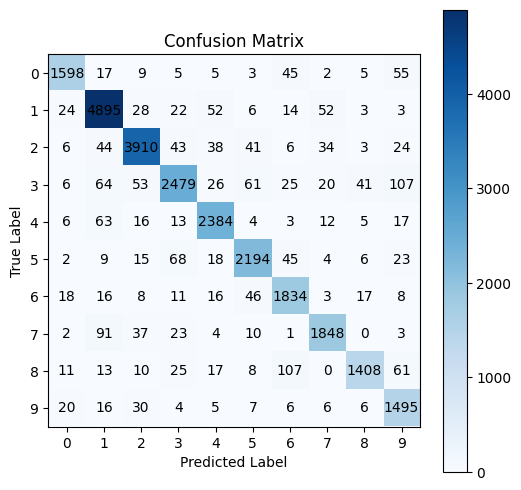

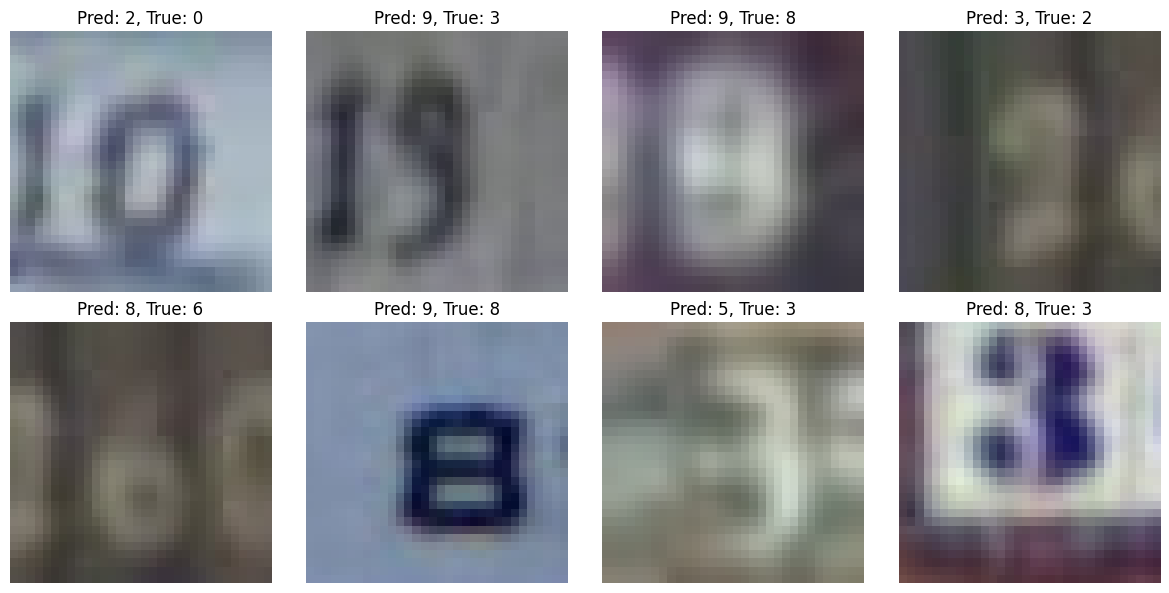

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, dataloader, num_classes=10):
    # Initialize an empty NxN matrix, where N=num_classes
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            for true_label, pred_label in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                conf_matrix[true_label, pred_label] += 1

    return conf_matrix

# Compute confusion matrix on the test set
cm = compute_confusion_matrix(model, test_loader, num_classes=10)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, cmap='Blues')

# Show all ticks and label them
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Annotate each cell with the number of samples
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

plt.colorbar(im, ax=ax)
plt.show()

model.eval()
misclassified_images = []
misclassified_preds = []
true_labels_list = []

# Original (unaugmented) dataset to display raw images
original_dataset = raw_test_loader.dataset

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        
        # Where the predictions do NOT match the ground truth
        mismatches = (preds != labels)
        
        # Get the actual tensor indices for which predictions fail
        if mismatches.any():
            for i, is_mismatch in enumerate(mismatches):
                if is_mismatch:
                    # Use the index to retrieve the original image
                    idx = test_loader.dataset.indices[i] if hasattr(test_loader.dataset, 'indices') else i
                    original_image, _ = original_dataset[idx]
                    
                    misclassified_images.append(original_image)
                    misclassified_preds.append(preds[i].item())
                    true_labels_list.append(labels[i].item())

# Show just a few misclassified samples
num_to_show = 8
fig, axes = plt.subplots(2, 4, figsize=(12,6))

for i in range(min(num_to_show, len(misclassified_images))):
    row, col = divmod(i, 4)
    ax = axes[row][col]
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(np.clip(img, 0, 1))  # Ensure image values are in range [0, 1]
    ax.set_title(f"Pred: {misclassified_preds[i]}, True: {true_labels_list[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Part 2: Adversarial Attacks on our Model

Implement the FGSM algorithm as shown in the tutorial (it may be necessary to make require_grad be True for our input data in order to calculate its gradient). Define a function ```eval_adversarial(model, test_loader, epsilon)``` that applies FGSM on the test data by creating new images which are perturbed versions of the originals, and calculates the model's accuracy only on the perturbed images. Test accuracy after the attack should be less than 25% for $\varepsilon=0.1$.

In [19]:
import torch
import torch.nn.functional as F

def fgsm_attack(image, epsilon, data_grad):
    """
    Given the gradient of the loss w.r.t. the input image (data_grad),
    construct an adversarial example by adjusting each pixel of the
    original image in the direction of the gradient's sign.
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel
    perturbed_image = image + epsilon * sign_data_grad
    
    # Clip the perturbed image to [0, 1] to maintain valid image range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

def eval_adversarial(model, test_loader, epsilon, device='cuda'):
    """
    Generates FGSM adversarial examples with perturbation size `epsilon`
    and computes the model's accuracy on these perturbed inputs.
    """
    
    # Switch the model to evaluation mode
    model.eval()
    
    correct = 0
    total = 0
    
    # We don't need to track gradients for model parameters,
    # but we DO need them for the input images.
    for images, labels in test_loader:
        
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Set requires_grad attribute of tensor. Important for FGSM!
        images.requires_grad = True
        
        # Forward pass the data through the model
        outputs = model(images)
        _, init_pred = outputs.max(1)  # Initial (clean) predicted class
        
        # If the initial prediction is wrong, no need to craft an adversarial example
        # for that sample (some implementations skip). But it’s optional to do so.
        
        # Calculate the loss
        loss = F.cross_entropy(outputs, labels)
        
        # Zero all existing gradients
        model.zero_grad()
        
        # Backward pass to calculate gradients of the loss w.r.t. the inputs
        loss.backward(retain_graph=False)
        
        # Collect the data gradient
        data_grad = images.grad.data
        
        # Call the FGSM attack
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
        
        # Re-classify the perturbed images
        outputs_perturbed = model(perturbed_images)
        _, final_pred = outputs_perturbed.max(1)
        
        # Check for success of the attack -> compare final_pred with labels
        correct += (final_pred == labels).sum().item()
        total += labels.size(0)
    
    adv_acc = 100.0 * correct / total
    return adv_acc

# Suppose we have a trained model, and a DataLoader called test_loader

epsilon = 0.1  # size of the perturbation
adversarial_acc = eval_adversarial(model, test_loader, epsilon, device=device)
print(f'FGSM Attack (epsilon={epsilon:.3f}) -> Adversarial Accuracy: {adversarial_acc:.2f}%')


FGSM Attack (epsilon=0.100) -> Adversarial Accuracy: 17.03%


### Visualization

Visualize some images that the model got right before the perturbation and wrong after the attack. Create a confusion matrix of the output on the entire test set.

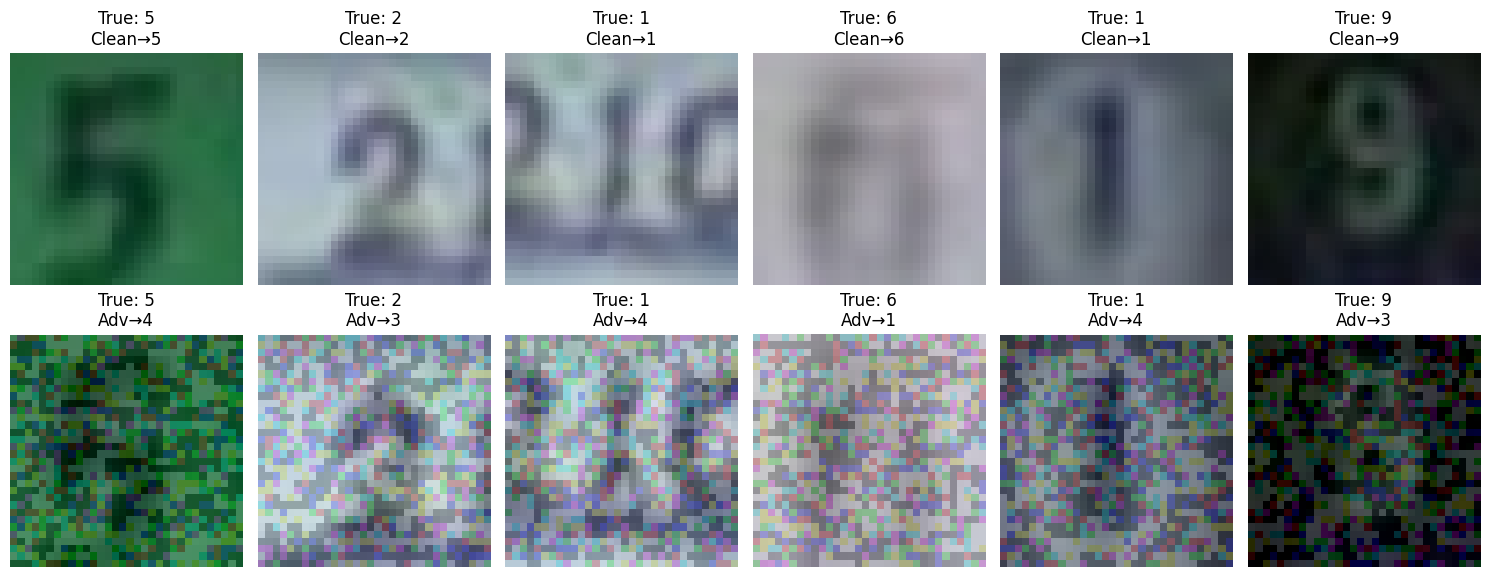

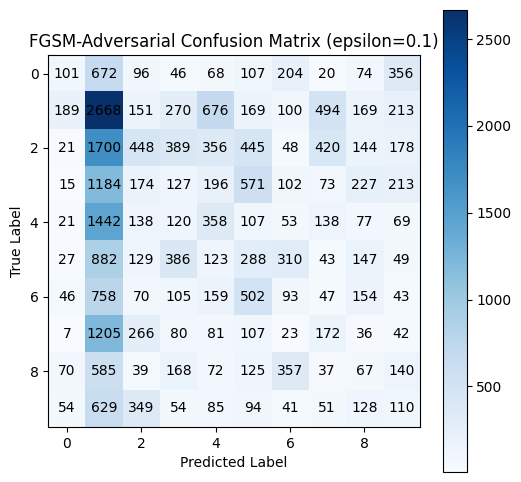

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_flipped_fgsm(model, loader, epsilon=0.1, device='cuda', num_show=6):
    model.eval()
    flipped_samples = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # 1) Forward pass on clean images (no gradient needed)
        with torch.no_grad():
            outputs_clean = model(images)
            _, preds_clean = outputs_clean.max(1)

        # 2) FGSM requires gradients on the input, so enable it
        images.requires_grad = True
        
        # Forward again with grad tracking
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        # Zero old gradients, then backward
        model.zero_grad()
        loss.backward()

        # Sign of the gradient
        grad_sign = images.grad.data.sign()

        # 3) Create adversarial images
        adv_images = images + epsilon * grad_sign
        adv_images = torch.clamp(adv_images, 0, 1)

        # 4) Forward pass on adversarial images
        with torch.no_grad():
            outputs_adv = model(adv_images)
            _, preds_adv = outputs_adv.max(1)

        # Find which samples are correct on clean but wrong on adv
        for i in range(images.size(0)):
            if preds_clean[i] == labels[i] and preds_adv[i] != labels[i]:
                # Save up to num_show examples
                if len(flipped_samples) < num_show:
                    # Detach & move to CPU for visualization
                    flipped_samples.append((images[i].detach().cpu(),
                                            preds_clean[i].item(),
                                            adv_images[i].detach().cpu(),
                                            preds_adv[i].item(),
                                            labels[i].item()))
                else:
                    break

        # Early stop if we have enough to display
        if len(flipped_samples) >= num_show:
            break

    # --- Visualization ---
    fig, axes = plt.subplots(2, num_show, figsize=(15, 6))

    for idx, (img_clean, pred_clean, img_adv, pred_adv, true_label) in enumerate(flipped_samples):
        # Original image
        ax = axes[0, idx]
        img_np = img_clean.permute(1, 2, 0).numpy()
        ax.imshow(np.clip(img_np, 0, 1))
        ax.set_title(f"True: {true_label}\nClean→{pred_clean}")
        ax.axis('off')

        # Adversarial image
        ax = axes[1, idx]
        img_np_adv = img_adv.permute(1, 2, 0).numpy()
        ax.imshow(np.clip(img_np_adv, 0, 1))
        ax.set_title(f"True: {true_label}\nAdv→{pred_adv}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_flipped_fgsm(model, raw_test_loader, epsilon=0.1, device=device, num_show=6)

import numpy as np
import matplotlib.pyplot as plt

def fgsm_confusion_matrix(model, loader, epsilon=0.1, device='cuda', num_classes=10):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        # Forward pass + compute loss
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        
        # Backprop to get gradients
        model.zero_grad()
        loss.backward()
        
        # Generate adversarial samples
        grad_sign = images.grad.data.sign()
        adv_images = images + epsilon * grad_sign
        adv_images = torch.clamp(adv_images, 0, 1)
        
        # Get adversarial predictions
        with torch.no_grad():
            outputs_adv = model(adv_images)
            _, preds_adv = outputs_adv.max(1)
        
        # Update confusion matrix
        for t, p in zip(labels.cpu().numpy(), preds_adv.cpu().numpy()):
            conf_matrix[t, p] += 1
    
    return conf_matrix

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    fig.colorbar(cax)

    # Label the axes
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Annotate each cell with the number of samples
    n_classes = cm.shape[0]
    for i in range(n_classes):
        for j in range(n_classes):
            text = ax.text(j, i, cm[i, j],
                           ha='center', va='center', color='black')
    plt.show()

# Compute confusion matrix on FGSM-perturbed test set
cm_adv = fgsm_confusion_matrix(model, test_loader, epsilon=0.1, device=device, num_classes=10)

# Plot the confusion matrix
plot_confusion_matrix(cm_adv, title='FGSM-Adversarial Confusion Matrix (epsilon=0.1)')


Epsilon = 0.000 -> Adversarial Accuracy: 62.20%
Epsilon = 0.010 -> Adversarial Accuracy: 52.03%
Epsilon = 0.050 -> Adversarial Accuracy: 26.21%
Epsilon = 0.100 -> Adversarial Accuracy: 17.03%
Epsilon = 0.200 -> Adversarial Accuracy: 12.62%


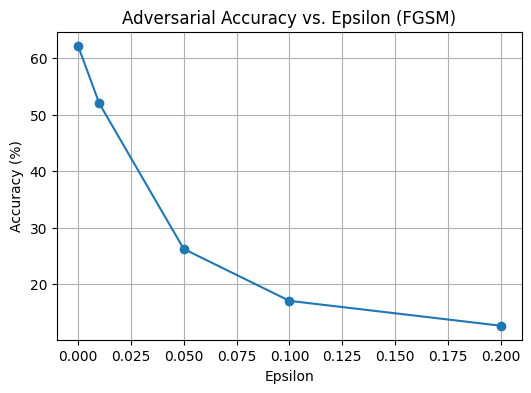

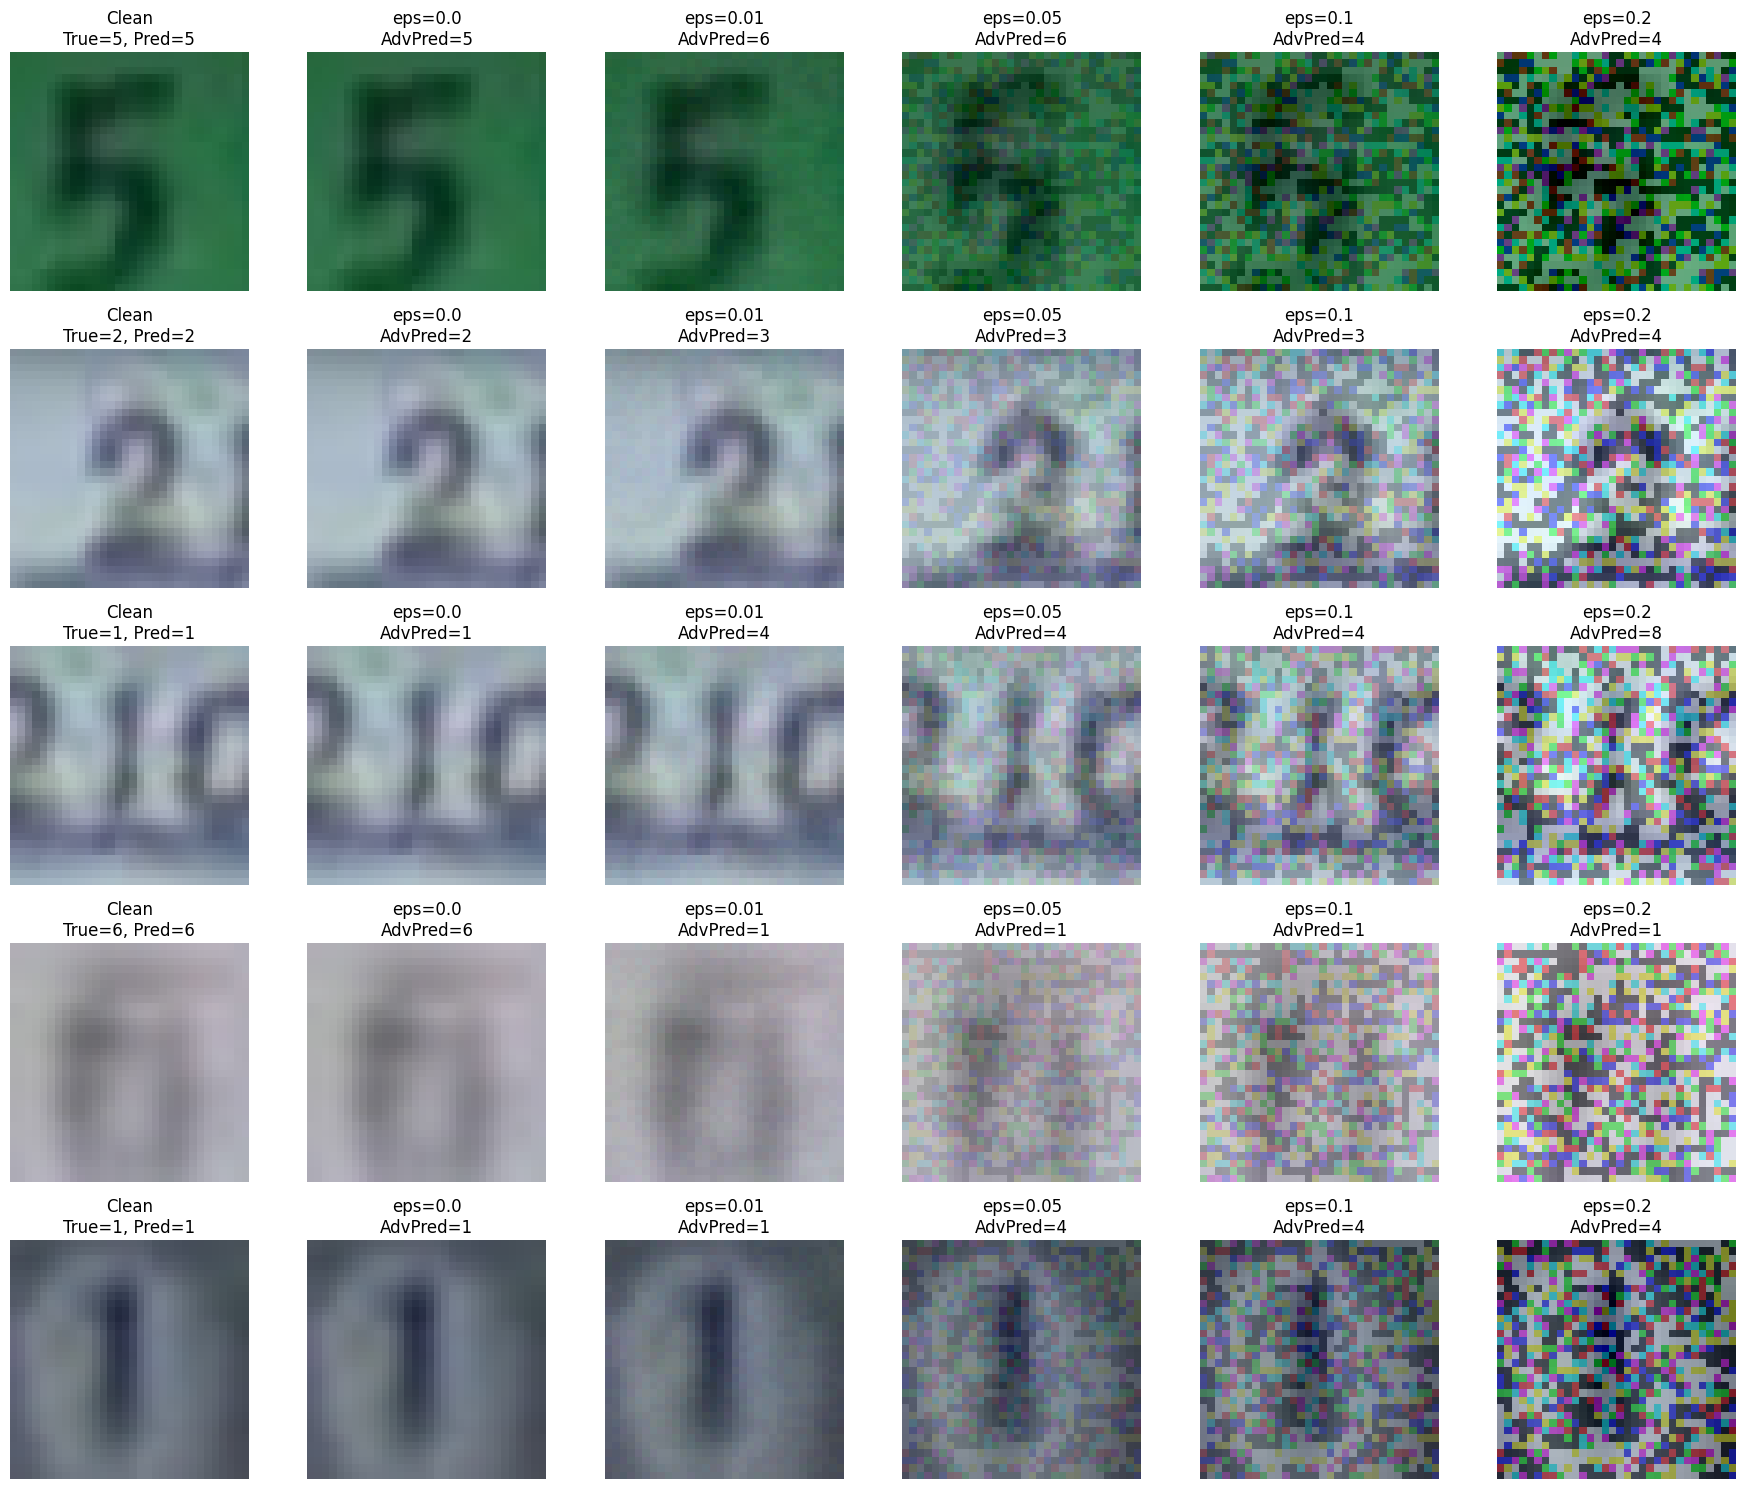

In [ ]:
import matplotlib.pyplot as plt

def test_fgsm_multiple_epsilons(model, test_loader, epsilons, device='cuda'):
    """
    Runs FGSM attack on test_loader for each epsilon in 'epsilons'.
    Returns a list of adversarial accuracies.
    """
    # We'll use the eval_adversarial function you defined earlier
    model.eval()

    accuracies = []
    for eps in epsilons:
        adv_acc = eval_adversarial(model, test_loader, eps, device=device)
        accuracies.append(adv_acc)
        print(f"Epsilon = {eps:.3f} -> Adversarial Accuracy: {adv_acc:.2f}%")
    return accuracies

# Example usage:
epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]  
acc_list = test_fgsm_multiple_epsilons(model, test_loader, epsilons, device=device)

plt.figure(figsize=(6,4))
plt.plot(epsilons, acc_list, marker='o', linestyle='-')
plt.title('Adversarial Accuracy vs. Epsilon (FGSM)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

import torch
import torch.nn.functional as F
import numpy as np

def display_perturbations(model, images, labels, epsilons, device='cuda', num_show=5):
    """
    For a small batch (images, labels), show how the images look after being perturbed
    by FGSM with different epsilons, along with the predicted labels.
    """
    # We'll just take the first 'num_show' samples
    model.eval()

    # Move data to device
    images = images.to(device)
    labels = labels.to(device)

    # Verify which of the first samples are correct at epsilon=0
    with torch.no_grad():
        outputs_clean = model(images)
        _, preds_clean = outputs_clean.max(1)

    # We'll store only those that are correct at baseline
    correct_indices = []
    for i in range(images.size(0)):
        if preds_clean[i] == labels[i]:
            correct_indices.append(i)

    # If we have fewer than num_show correct images, adjust
    correct_indices = correct_indices[:num_show]

    # Plot
    fig, axes = plt.subplots(len(correct_indices), len(epsilons)+1, figsize=(3*(len(epsilons)+1), 3*len(correct_indices)))
    if len(correct_indices) == 1:
        axes = [axes]  # Make it iterable if there's only one row
    
    for row_idx, idx in enumerate(correct_indices):
        # Row = one image, columns = [original, eps1, eps2, ...]
        # 1) Show the original image (with no attack)
        img_clean = images[idx].detach().cpu().clone()
        # Convert for display
        img_disp = img_clean.permute(1, 2, 0).numpy()
        axes[row_idx][0].imshow(np.clip(img_disp, 0, 1))  # or denormalize if needed
        axes[row_idx][0].set_title(f"Clean\nTrue={labels[idx].item()}, Pred={preds_clean[idx].item()}")
        axes[row_idx][0].axis('off')

        # 2) For each epsilon, craft adv image & predict
        for col_idx, eps in enumerate(epsilons, start=1):
            adv_image = generate_fgsm_single(model, img_clean.to(device).unsqueeze(0), labels[idx].unsqueeze(0), eps)
            
            # Evaluate
            with torch.no_grad():
                out_adv = model(adv_image)
                _, pred_adv = out_adv.max(1)
            
            # Convert to CPU for display
            adv_image_cpu = adv_image.squeeze(0).cpu().permute(1,2,0).detach().numpy()  # <--- Fixed here
        
            axes[row_idx][col_idx].imshow(np.clip(adv_image_cpu, 0, 1))
            axes[row_idx][col_idx].set_title(f"eps={eps}\nAdvPred={pred_adv.item()}")
            axes[row_idx][col_idx].axis('off')


    plt.tight_layout()
    plt.show()

def generate_fgsm_single(model, image, label, epsilon):
    """
    Generates an FGSM adversarial sample for a single image, label pair.
    `image` shape: (1, C, H, W)
    """
    # Make a copy so we don't overwrite original
    adv_image = image.clone().detach().requires_grad_(True)
    
    # Forward pass
    output = model(adv_image)
    loss = F.cross_entropy(output, label)

    # Zero gradients
    model.zero_grad()
    loss.backward()

    # FGSM step
    adv_image = adv_image + epsilon * adv_image.grad.sign()
    adv_image = torch.clamp(adv_image, 0, 1)

    return adv_image

# Example usage:
# We'll grab a small batch from the test_loader to visualize
data_iter = iter()
images_batch, labels_batch = next(data_iter)

# We'll pick the same epsilons as above
epsilons_for_display = [0.0, 0.01, 0.05, 0.1, 0.2]

display_perturbations(model, images_batch, labels_batch, epsilons_for_display, device=device, num_show=5)

## Part 3: Training our model using adversarial training

For each point in the training data, increase the model's robustness by training not only on the point itself, but on the perturbed point after the FGSM algorithm using $\varepsilon=0.1$. Afterwards, compute the accuracy once again on the newly trained model using ```eval_adversarial(model, test_loader, epsilon)``` defined above. The accuracy (LOOKING ONLY AT THE PERTURBED DATA) should be at least 70%. 

In [25]:
import torch
import torch.nn as nn

def train_one_epoch_adv(model, train_loader, optimizer, criterion, epsilon=0.1, device='cuda'):
    """
    One epoch of adversarial training using FGSM with a fixed epsilon.
    For each batch:
      1) Compute loss on clean images
      2) Generate FGSM adversarial images
      3) Compute loss on adversarial images
      4) Backprop on the combined (clean + adv) loss
    """
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1) Forward pass on clean images
        images.requires_grad = True
        outputs_clean = model(images)
        loss_clean = criterion(outputs_clean, labels)

        # 2) Generate FGSM adversarial images
        model.zero_grad()
        loss_clean.backward(retain_graph=True)  # keep graph for adv pass
        data_grad = images.grad.data  # gradient wrt input
        adv_images = fgsm_attack(images, epsilon, data_grad)  # from  FGSM function

        # 3) Forward pass on adversarial images
        adv_outputs = model(adv_images)
        loss_adv = criterion(adv_outputs, labels)

        # Combine the losses (there are multiple strategies; here we sum them)
        loss = loss_clean + loss_adv

        # 4) Backprop combined loss & update
        model.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def adversarial_train(model, train_loader, test_loader, 
                      criterion, optimizer, 
                      num_epochs=5, epsilon=0.1, device='cuda'):
    """
    Full adversarial training loop for a specified number of epochs.
    """
    for epoch in range(num_epochs):
        train_loss = train_one_epoch_adv(
            model, train_loader, optimizer, criterion, epsilon, device=device
        )
        

    # After training, evaluate specifically on adversarial data
    adv_acc = eval_adversarial(model, test_loader, epsilon, device=device)
    print(f"Final Adversarial Accuracy at epsilon={epsilon}: {adv_acc:.2f}%")
    return adv_acc

# Example usage:
num_epochs = 50
epsilon = 0.170

# Define your criterion, optimizer, etc.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Perform adversarial training
final_adv_acc = adversarial_train(
    model, 
    train_loader,  #  training dataloader
    test_loader,   #  test dataloader
    criterion, 
    optimizer, 
    num_epochs=num_epochs, 
    epsilon=epsilon,
    device=device
)

print(f"Adversarial Accuracy after training: {final_adv_acc:.2f}%")


Final Adversarial Accuracy at epsilon=0.17: 77.72%
Adversarial Accuracy after training: 77.72%


### Visualization

Display the confusion matrix along with some examples of images that the model classified incorrectly. Discuss the performance of the model now compared to before.

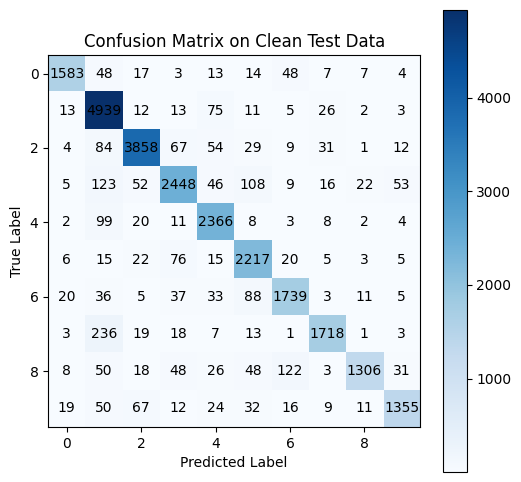

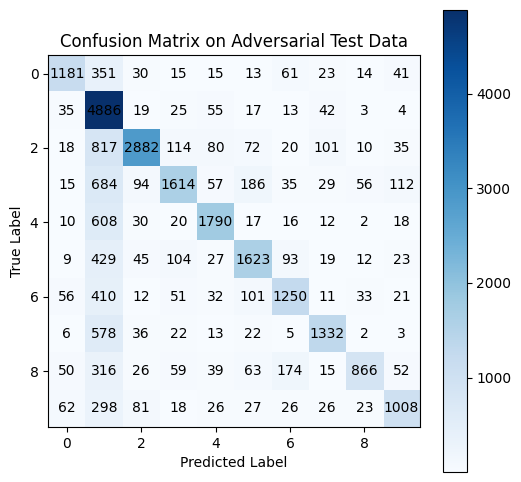

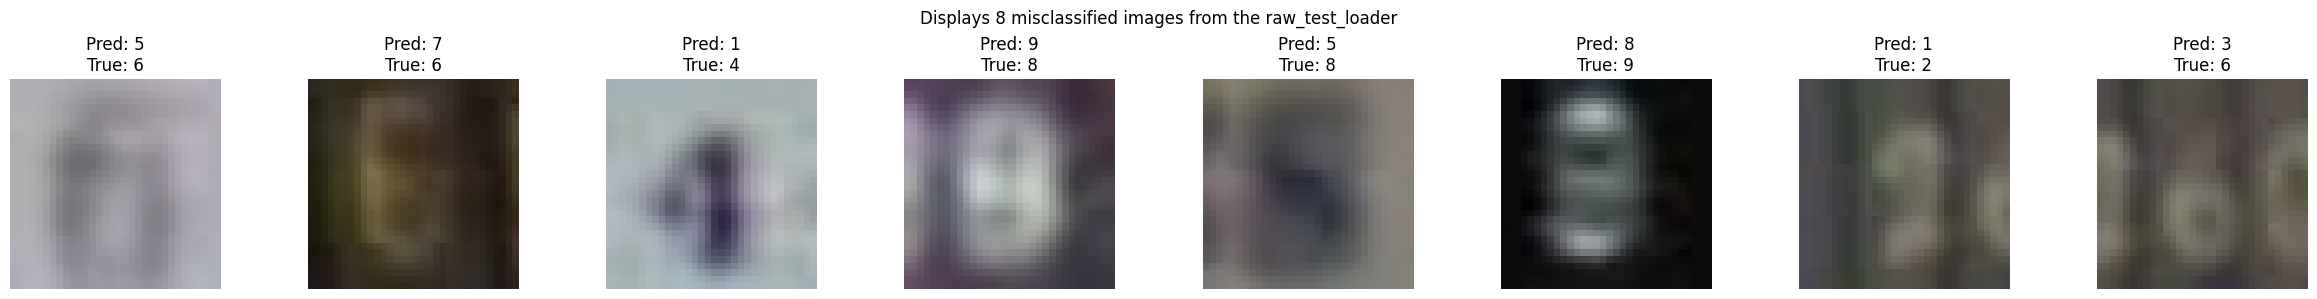

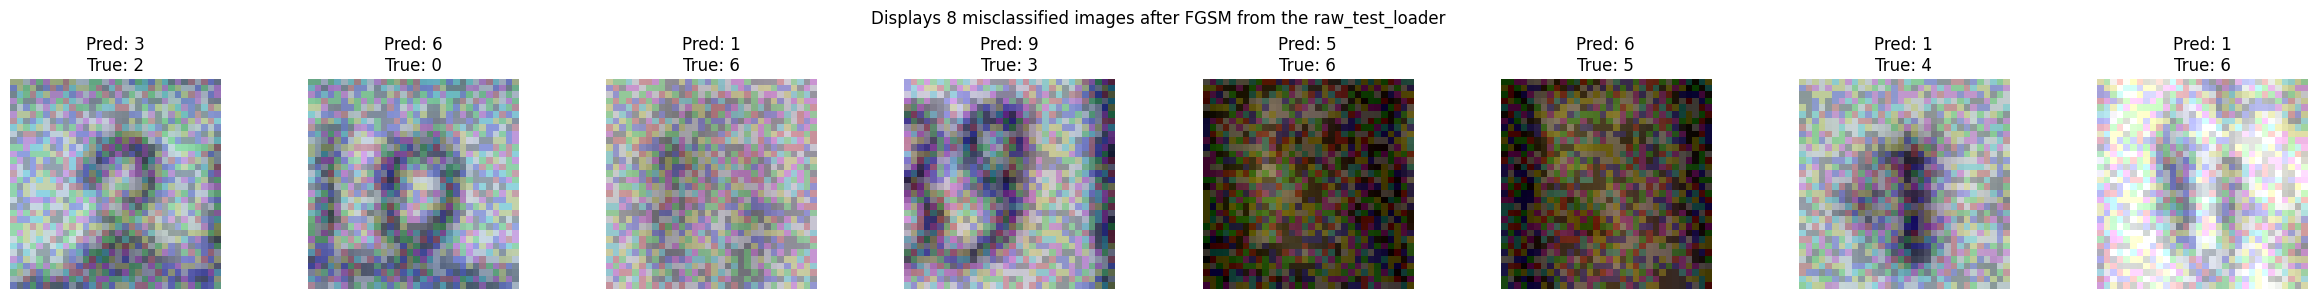

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, loader, num_classes=10, device='cuda'):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            for t, p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                conf_matrix[t, p] += 1
    
    return conf_matrix

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    fig.colorbar(cax)
    
    # Label the axes
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # Annotate each cell with the number of samples
    n_classes = cm.shape[0]
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center', color='black')
    plt.show()

# Example usage:
cm_clean = compute_confusion_matrix(model, test_loader, num_classes=10, device=device)
plot_confusion_matrix(cm_clean, title='Confusion Matrix on Clean Test Data')

def compute_confusion_matrix_adversarial(model, loader, epsilon=0.1, num_classes=10, device='cuda'):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        # Forward pass to get gradient
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        
        model.zero_grad()
        loss.backward()

        # FGSM perturbation
        data_grad = images.grad.data
        adv_images = fgsm_attack(images, epsilon, data_grad)

        # Predict on adversarial images
        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, preds_adv = adv_outputs.max(1)
        
        for t, p in zip(labels.cpu().numpy(), preds_adv.cpu().numpy()):
            conf_matrix[t, p] += 1

    return conf_matrix

# And then plot similarly:
cm_adv = compute_confusion_matrix_adversarial(model, test_loader, epsilon=0.1, device=device)
plot_confusion_matrix(cm_adv, title='Confusion Matrix on Adversarial Test Data')

def show_misclassified(model, loader, device='cuda', num_show=8):
    """
    Displays 'num_show' misclassified images from the loader.
    """
    model.eval()
    misclassified_imgs = []
    misclassified_preds = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            # Boolean mask of misclassifications
            mismatches = (preds != labels)
            
            # Collect them
            for i in range(images.size(0)):
                if mismatches[i]:
                    misclassified_imgs.append(images[i].cpu())
                    misclassified_preds.append(preds[i].item())
                    true_labels.append(labels[i].item())
                    
                    if len(misclassified_imgs) >= num_show:
                        break
            if len(misclassified_imgs) >= num_show:
                break
    
    # Visualize
    fig, axes = plt.subplots(1, num_show, figsize=(3*num_show, 3))
    fig.suptitle("Displays 8 misclassified images from the raw_test_loader")
    for i, ax in enumerate(axes):
        img = misclassified_imgs[i].permute(1,2,0).numpy()
        ax.imshow(np.clip(img, 0, 1))  # If 0-1 scaled
        ax.set_title(f"Pred: {misclassified_preds[i]}\nTrue: {true_labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage for clean data:
show_misclassified(model, raw_test_loader, device=device, num_show=8)

def show_misclassified_adv(model, loader, epsilon=0.1, device='cuda', num_show=8):
    """
    Displays 'num_show' misclassified images (after FGSM) from the loader.
    """
    model.eval()
    misclassified_imgs = []
    misclassified_preds = []
    true_labels = []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = images.grad.data
        adv_images = fgsm_attack(images, epsilon, data_grad)
        
        with torch.no_grad():
            outputs_adv = model(adv_images)
            _, preds_adv = outputs_adv.max(1)
        
        # Identify misclassifications after attack
        mismatches = (preds_adv != labels)
        
        for i in range(images.size(0)):
            if mismatches[i]:
                misclassified_imgs.append(adv_images[i].detach().cpu())
                misclassified_preds.append(preds_adv[i].item())
                true_labels.append(labels[i].item())
                
                if len(misclassified_imgs) >= num_show:
                    break
        if len(misclassified_imgs) >= num_show:
            break

    # Visualize
    fig, axes = plt.subplots(1, num_show, figsize=(3*num_show, 3))
    fig.suptitle("Displays 8 misclassified images after FGSM from the raw_test_loader")
    for i, ax in enumerate(axes):
        img = misclassified_imgs[i].unsqueeze(0).squeeze().permute(1,2,0).detach().numpy()
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(f"Pred: {misclassified_preds[i]}\nTrue: {true_labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage for adversarial data:
show_misclassified_adv(model, raw_test_loader, epsilon=0.1, device=device, num_show=8)


## Part 4: Contrastive Learning

In this section, we will work on creating informative embeddings for images using SimCLR. For this section we will use the attached subset of the popular ImageNet dataset of 96x96 images from 1000 classes. Below, we provide you with several functions to implement a contrastive learning model.

### Dry Questions

Before implementation, take these questions in consideration (and provide your answers and explanations):

1. When training an unsupervised contrastive learning model such as SimCLR, would we prefer to have a large or small batch size?
2. In general, what possible evaluation metrics could be used in this task (unsupervised representation learning) to measure our model's performance?
3. When creating embeddings for images in the test set, how does the process differ from what we do in training?
4. For each of the following image augmentations, explain whether or not we would like to use them in the SimCLR framework:
    - Randomly cropping a fixed-size window in the image.
    - Enlarging the image to 128x128.
    - Random rotation of the image.
    - Adding Gaussian noise.
    - Randomly changing the image's dimensions.
    - Randomly converting the image to grayscale.

### Code

Do the following:

1. Create a CNN that makes embeddings for images (you can use pretrained foundation models if you'd like).
2. Implement any unsupervised contrastive loss (such as nt-xent in SimCLR).
3. Train the model (achieve loss less than 3.0).

In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.models as models

TRAIN_PATH = "extracted_tiny_imagenet200/tiny-imagenet-200/train"   
TEST_PATH  = "extracted_tiny_imagenet200/tiny-imagenet-200/test"    
BATCH_SIZE = 256
NUM_EPOCHS = 5
LR         = 3e-3
TEMPERATURE= 0.07
OUT_DIM     = 64

In [31]:
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class TrainDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = []
        for class_id in os.listdir(root):
            class_dir = os.path.join(root, class_id)
            images_dir = os.path.join(class_dir, 'images')
            if os.path.isdir(images_dir):
                for img_file in os.listdir(images_dir):
                    self.imgs.append(os.path.join(images_dir, img_file))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        else:
            img1, img2 = img, img
        return img1, img2

class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = []
        images_dir = os.path.join(root, 'images')
        for img_file in os.listdir(images_dir):
            self.imgs.append(os.path.join(images_dir, img_file))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img_transform = self.transform(img)
        else:
            img_transform = img
        return T.ToTensor()(img), img_transform


# ---------------------- Data Transforms ------------------------
# Optionally reduce or simplify augmentations if you want an even faster drop in loss
data_transforms = T.Compose([
    T.RandomResizedCrop(96, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    # You could remove some of these to reduce complexity:
    T.RandomApply([
        T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    # T.RandomGrayscale(p=0.2),  # Optionally comment out
    T.ToTensor(),
])

test_transforms = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor(),
])

# -------------------- DataLoaders -----------------------------
train_data = TrainDataset(TRAIN_PATH, transform=data_transforms)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_data = TestDataset(TEST_PATH, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


# ------------------ Model: Encoder + Projector ----------------
class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=OUT_DIM):
        super().__init__()
        self.encoder = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.encoder.fc = nn.Identity()  # output is 512-d
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        h = self.encoder(x)  # [B, 512]
        z = self.projector(h) # [B, out_dim]
        return h, z


# ------------------ Contrastive Loss (NT-Xent) ----------------
def nt_xent_loss(z1, z2, temperature=TEMPERATURE):
    B = z1.size(0)
    # Normalize
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    # Concat => shape [2B, dim]
    z = torch.cat([z1, z2], dim=0)
    # Similarity => shape [2B, 2B]
    sim = torch.matmul(z, z.T) / temperature
    # Set diagonal = -inf
    diag_mask = torch.eye(2*B, device=z1.device).bool()
    sim[diag_mask] = float('-inf')
    # Labels
    labels = torch.arange(B, device=z1.device)
    labels = torch.cat([labels + B, labels], dim=0)
    loss = F.cross_entropy(sim, labels)
    return loss


# -------------------- Training Loop ---------------------------
def train_simclr(model, loader, epochs=NUM_EPOCHS, lr=LR, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        with tqdm(loader, unit="batch") as tepoch:
            for img1, img2 in tepoch:
                img1, img2 = img1.to(device), img2.to(device)
                # Forward pass
                _, z1 = model(img1)
                _, z2 = model(img2)
                # Contrastive loss
                loss = nt_xent_loss(z1, z2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
                # Update tqdm description and loss
                tepoch.set_description(f"Epoch [{epoch+1}/{epochs}]")
                tepoch.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


# ----------------- Putting It All Together --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = SimCLRModel(base_model='resnet18', out_dim=OUT_DIM)
    
    train_simclr(
        model,
        train_loader,
        epochs=NUM_EPOCHS,
        lr=LR,
        device=device
    )

Epoch [5/5]: 100%|██████████| 390/390 [09:00<00:00,  1.39s/batch, loss=0.649]

Epoch [5/5], Loss: 0.6051


Using the function ```plot_embeddings```, show the model's performance on the test data. 

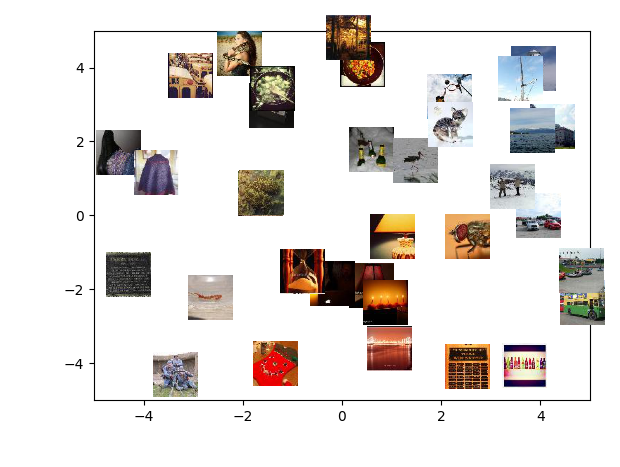

In [32]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

def plot_embeddings(model, test_loader, device='cuda'):
    """
    This function creates embeddings for each image in the first batch of the test loader,
    projects them to 2D, and displays them on a plot.
    """
    for img, img_transform in test_loader:
        img_transform = img_transform.to(device)
        # Forward pass to obtain embeddings
        _, embeddings = model(img_transform)  # Extract the second part of the tuple
        embeddings = embeddings.cpu().detach().numpy()

        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Plot embeddings
        fig, ax = plt.subplots()
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        for i in range(embeddings_2d.shape[0]):
            curr_img = img[i].permute(1, 2, 0)
            curr_img = OffsetImage(curr_img, zoom=0.5)
            ab = AnnotationBbox(curr_img, embeddings_2d[i], frameon=False)
            ax.add_artist(ab)
        return  # Only visualize the first batch

plot_embeddings(model, test_loader)


For some batch of the test loader, take 3 images in the batch. For each image, find and display the 5 images that have the closest embeddings to them. Do the chosen images make sense? If not, what could have possibly gone wrong with your model?

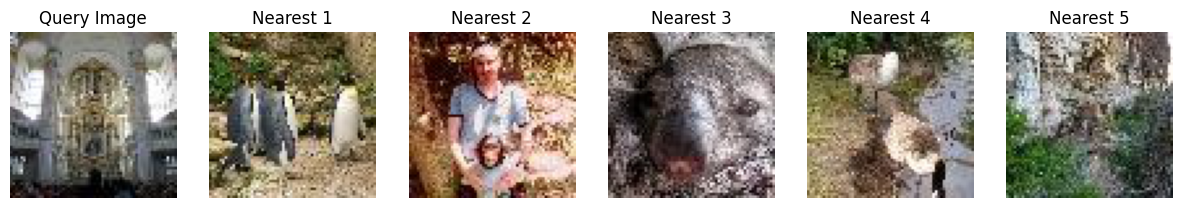

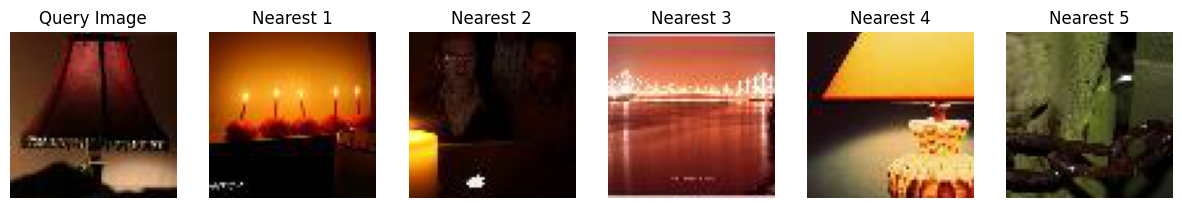

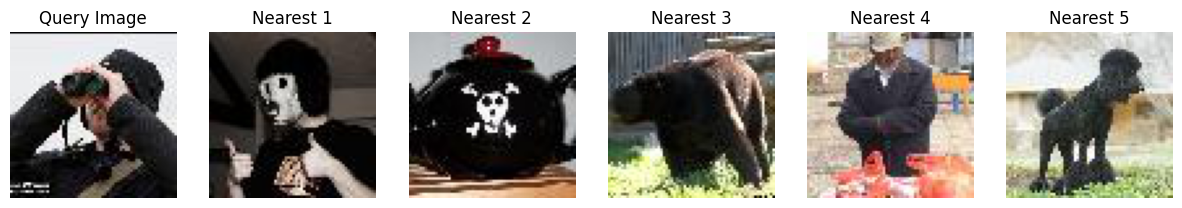

In [33]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_nearest_images(model, test_loader, device='cuda', query_count=3, nearest_count=5):
    """
    Visualizes the nearest images for randomly selected queries from the test_loader.

    Parameters:
        model: Trained SimCLR model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the model on ('cuda' or 'cpu').
        query_count: Number of query images to visualize.
        nearest_count: Number of nearest images to find for each query.
    """
    model.eval()
    with torch.no_grad():
        for original_images, transformed_images in test_loader:
            transformed_images = transformed_images.to(device)
            # Get embeddings from the model
            _, embeddings = model(transformed_images)
            embeddings = F.normalize(embeddings, p=2, dim=1)

            # Randomly select query images
            random_indices = torch.randint(0, len(original_images), (query_count,))
            query_images = original_images[random_indices]
            query_embeddings = embeddings[random_indices]

            # Calculate pairwise distances
            pairwise_distances = torch.cdist(query_embeddings, embeddings, p=2)

            for i, (query_img, distances) in enumerate(zip(query_images, pairwise_distances)):
                # Get the indices of the nearest images (excluding the query itself)
                nearest_indices = distances.topk(nearest_count + 1, largest=False).indices[1:]

                # Create a plot for the query and nearest images
                fig, axes = plt.subplots(1, nearest_count + 1, figsize=(15, 5))
                axes[0].imshow(query_img.permute(1, 2, 0))
                axes[0].set_title("Query Image")
                axes[0].axis("off")

                for j, nearest_idx in enumerate(nearest_indices):
                    nearest_img = original_images[nearest_idx].permute(1, 2, 0)
                    axes[j + 1].imshow(nearest_img)
                    axes[j + 1].set_title(f"Nearest {j + 1}")
                    axes[j + 1].axis("off")

                plt.show()

            break
        
visualize_nearest_images(model, test_loader, device=device)
